# Basic usage of modified transformers library (modification have been done only for BERT) 


### To run this notebook: Clone this repo and install the modified library.

### https://github.com/gorokoba560/norm-analysis-of-transformer

## Install the changed library (only first once)

1. move into the modified library
> $ cd transformers

1. install using pip (I recommend editable mode (-e option).)
> $ pip install -e .

1. please install pytorch (https://pytorch.org/) \
 e.g., 
 > $ pip install torch torchvision

## Usage

In [151]:
%load_ext autoreload
%autoreload 2

In [156]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import transformers
from sklearn.metrics import *
from transformers import AdamW
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split as tts
from transformers import BertTokenizerFast, BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

In [119]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[  101,  2182,  2003,  2070,  3793,  2000,  4372, 16044,   102]])
['[CLS]', 'here', 'is', 'some', 'text', 'to', 'en', '##code', '[SEP]']


In [120]:
# If you want to extract vector norms (i.e., ||f(x)||, ||αf(x)||, ||Σαf(x)||), please set the argument "output_norms" to True.
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [121]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [122]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [123]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 9])


In [124]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 9, 9])


In [125]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 9, 9])


## Comparison with attention weight

In [126]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 8
head = 5

### Attention weight visualization (Head-level visualization)

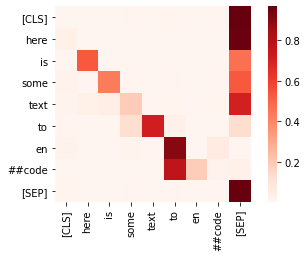

In [127]:
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)

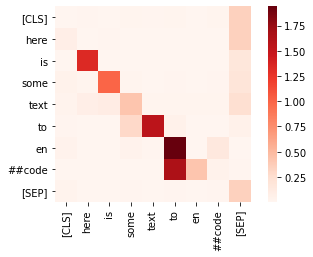

In [128]:
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention weight visualization (Layer-level visualization)

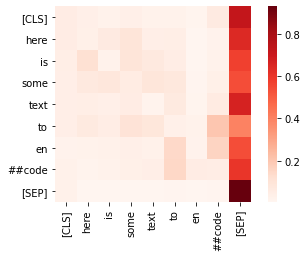

In [129]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)

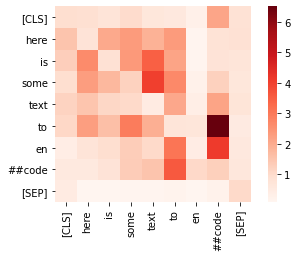

In [130]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

## Experiment with S3 code

## Prepare the data 

In [14]:
# Download humor detection data
# Paper: https://arxiv.org/abs/2004.12765
#data = pd.read_csv("https://raw.githubusercontent.com/Moradnejad/ColBERT-Using-BERT-Sentence-Embedding-for-Humor-Detection/master/Data/dataset.csv")
#print("\nThere are", len(data), "sentences")

# Use the standard text/label columns
# Create labels: 1 --> humorous, 0 --> not humorous
#data["label"] = data["humor"].apply(int)
#data.head()


There are 200000 sentences


,text,humor,label
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,0
1,Watch: darvish gave hitter whiplash with slow ...,False,0
2,What do you call a turtle without its shell? d...,True,1
3,5 reasons the 2016 election feels so personal,False,0
4,"Pasco police shot mexican migrant from behind,...",False,0


In [77]:
# # Read GEC dataset
data = pd.read_csv("GEC_sentences.csv")
print("\nThere are", len(data), "sentences")

 # Assign 1 to the erroneous sentences and zero to the rest
data["text"], data["label"] = data.sentence, data["type"].apply(lambda x: 1 if x=="erroneous" else 0)
del data["sentence"]
print(data.head())


There are 28350 sentences
        type                                               text  label
0    correct                              Dear Sir or Madam ,\n      0
1  erroneous  I am writing in order to express my disappoint...      1
2  erroneous  I saws the show 's advertisement hanging up of...      1
3  erroneous  The problems started in the box office , where...      1
4    correct  Moreover , the show was delayed forty - five m...      0


In [78]:
# Use a subset for quick experiments
subset_data = data[:10000]

# Split to train, val and test
train, test = tts(subset_data[["text", "label"]], random_state=42, test_size=0.1)
train, val = tts(train, random_state=42, test_size=test.shape[0])

#### Tokenize and encode with BERT tokenizer

In [79]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# A sanity check of the tokenizer
encoded_instance = bert_tokenizer.batch_encode_plus([train.iloc[0].text], padding=True)
print(encoded_instance)

{'input_ids': [[101, 6737, 2144, 11657, 2135, 1010, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}


In [80]:
print("Original text:", train.iloc[0].text)
print("BERT BPEs:", bert_tokenizer.convert_ids_to_tokens(encoded_instance["input_ids"][0]))

Original text: Yours sincerately ,

BERT BPEs: ['[CLS]', 'yours', 'since', '##rate', '##ly', ',', '[SEP]']


In [81]:
# Set max_len to the maximum length of the training data 
max_len = max([len(bert_tokenizer.encode(s)) for s in train.text.to_list()])
print("The maximum sentence length in training based on BERT BPEs is", max_len)

The maximum sentence length in training based on BERT BPEs is 138


In [82]:
# Tokenize and encode sentences in each set
x_train = bert_tokenizer.batch_encode_plus(
    train.text.tolist(),
    max_length = max_len,
    padding=True,
    truncation=True
)
x_val = bert_tokenizer.batch_encode_plus(
    val.text.tolist(),
    max_length = max_len,
    padding=True,
    truncation=True
)
x_test = bert_tokenizer.batch_encode_plus(
    test.text.tolist(),
    max_length = max_len,
    padding=True,
    truncation=True
)

In [83]:
# Convert lists to tensors in order to feed them to our PyTorch model
train_seq = torch.tensor(x_train['input_ids'])
train_mask = torch.tensor(x_train['attention_mask'])
train_y = torch.tensor(train.label.tolist())

val_seq = torch.tensor(x_val['input_ids'])
val_mask = torch.tensor(x_val['attention_mask'])
val_y = torch.tensor(val.label.tolist())

test_seq = torch.tensor(x_test['input_ids'])
test_mask = torch.tensor(x_test['attention_mask'])
test_y = torch.tensor(test.label.tolist())

In [84]:
batch_size = 32

# Create a dataloader for each set

# TensorDataset: Creates a PyTorch dataset object to load data from
train_data = TensorDataset(train_seq, train_mask, train_y)
# RandomSampler: specify the sequence of indices/keys used in data loading
train_sampler = RandomSampler(train_data)
# DataLoader: a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

### Build and train the model

In [85]:
# Define which BERT model to use
# We will use BERT base pre-trained on uncased text
model_name = "bert-base-uncased"
# The BertForSequenceClassification class creates a model with BERT and a classifier on top
# The classifier is a linear layer with two outputs (two is the default, if you have more labels change the config)
# It uses the CrossEntropyLoss from PyTorch
# from_pretrained() is used to load pre-trained weights

#N.B This is now the modified version of BERT that can output the norm of the vectors.

model = BertForSequenceClassification.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [86]:
# Training method
def training():
  # Set to train mode
  model.train()
  total_loss, total_accuracy = 0, 0
  # Iterate through the training batches
  for batch in tqdm(train_dataloader, desc="Iteration"):    
    # Push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # Clear gradients 
    model.zero_grad()
    # Get model outputs
    outputs = model(sent_id, attention_mask=mask, labels=labels)
    #print(outputs[1])
    # Get loss
    loss = outputs[0]
    # Add to the total loss
    total_loss = total_loss + loss
    # Backward pass to calculate the gradients
    loss.backward()
    # Update parameters
    optimizer.step()
  # Compute the training loss of the epoch
  epoch_loss = total_loss / len(train_dataloader)

  return epoch_loss

In [87]:
# Evaluation method
def evaluate():  
  print("\nEvaluating...")  
  # Set to eval mode
  model.eval()
  total_loss, total_accuracy = 0, 0
  predictions, targets = [], []
  # Iterate through the validation batches
  for batch in val_dataloader:
    # Push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    # Save the gold labels to use them for evaluation
    targets.extend(labels.detach().cpu().numpy())
    # Deactivate autograd
    with torch.no_grad():
      # Get model outputs
      outputs = model(sent_id, attention_mask=mask, labels=labels)
      # Get loss
      loss = outputs[0]
      total_loss = total_loss + loss
      logits = outputs[1]
      # Apply softmax to the output of the model
      output_probs = softmax(logits.detach().cpu().numpy(), axis=1)
      # Get the index with the largest probability as the predicted label
      predictions.extend(np.argmax(output_probs, axis=1))
  # Compute the validation loss of the epoch
  epoch_loss = total_loss / len(val_dataloader)

  return epoch_loss, targets, predictions

In [88]:
# Push model to gpu
#model = model.to(device)
# Define the optimizer and the learning rate
optimizer = AdamW(model.parameters(), lr = 2e-5)

best_val_loss = float('inf')
best_epoch = -1
train_losses=[]
val_losses=[]
epochs = 7
# Define the number of epochs to wait for early stopping
patience = 3

# Train the model
for epoch in range(epochs):     
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))    
  train_loss = training()
  val_loss, val_targets, val_predictions = evaluate()

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  print("\nTraining Loss:", train_loss)
  print("Validation Loss:", val_loss)
  # Calculate the validation F1 score for the current epoch
  f1 = f1_score(val_targets, val_predictions, average="binary")
  print("F1 score:", round(f1, 3))

  # Save the model with the best validation loss
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_epoch = epoch
    torch.save(model.state_dict(), 'saved_weights.pt')

  # Early stopping
  if ((epoch - best_epoch) >= patience):
    print("No improvement in", patience, "epochs. Stopped training.")
    break


 Epoch 1 / 7


Iteration:   0%|          | 0/250 [00:00<?, ?it/s]

output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output s

Iteration:   0%|          | 0/250 [00:00<?, ?it/s]

output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output s

Iteration:   0%|          | 0/250 [00:00<?, ?it/s]

output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output s

Iteration:   0%|          | 0/250 [00:00<?, ?it/s]

output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output shape: 2
output s

## Inference 

In [157]:
# Create the model
model_e = BertForSequenceClassification.from_pretrained("bert-base-uncased", output_attentions=True)
# Load pre-trained weights
checkpoint = torch.load("saved_weights.pt", map_location="cpu")
# Add them to the model
model_e.load_state_dict(checkpoint)
#model_e = model_e.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [158]:
# Predict for the test set and save the results
model_e.eval()
test_predictions = []
test_targets = []
test_attentions = []
test_inputs = []

for batch in test_dataloader:
  batch = [t.to(device) for t in batch]
  sent_id, mask, labels = batch
  # Get gold labels
  test_targets.extend(labels.detach().cpu().numpy())
  # Get input words
  test_inputs.append(bert_tokenizer.convert_ids_to_tokens(sent_id.detach().cpu().numpy()[0]))
  with torch.no_grad():
    # Get predictions
    probs, attention, norms = model_e(sent_id, attention_mask=mask, output_norms=True, output_attentions=True)
    # Apply softmax to the outputs
    output_probs = softmax(outputs[0].detach().cpu().numpy(), axis=1)
    # Get the with the highest probability as the predicted label
    test_predictions.extend(np.argmax(output_probs, axis=1))
    # Get attention weights
    # Attention weights from all layers are returned in a tuple
    # The weights from each layer are in a tensor with shape (batch_size, attention_heads, max_len, max_len)
    test_attentions.append(outputs[1])

## Attention and norm analysis

In [62]:
# Get attention heatmaps
import matplotlib
from IPython.core.display import display, HTML
def colorize(words, color_array):
    cmap=matplotlib.cm.Reds
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [160]:
print(len(attention))
print(attention[layer-1].shape)

12
torch.Size([1, 12, 84, 84])


In [161]:
print(len(norms))
print(len(norms[layer-1]))
norms[layer-1][0].shape

12
3


torch.Size([1, 12, 84])

In [100]:
# Lack of Subject-Verb Agreement
sentence1 = "She are going to the park."
# Pronoun Disagreement
sentence2 = "All girl brings their own lunch."

### Sentence 1 

In [93]:
# Encode the first sentence
encoded_sentence1 = bert_tokenizer.batch_encode_plus([sentence1], padding=True)

# Give as input to the model and get the outputs
inputs = torch.tensor(encoded_sentence1["input_ids"]).to(device)
att = torch.tensor(encoded_sentence1["attention_mask"]).to(device)
probs, attentions, norms = model_e(inputs, attention_mask=att, output_attentions=True, output_norms=True)

output shape: 3


In [102]:
# Get the predictions
output_probs = softmax(probs.detach().cpu().numpy(), axis=1)
predictions = (np.argmax(output_probs, axis=1))
print(sentence1, ":", predictions[0])

She are going to the park. : 1


### What does the CLS token attend to? How does it differ between weight based and norm-based analysis? 

In [95]:
# Visualize the attention heatmaps for the CLS token
tokens = bert_tokenizer.convert_ids_to_tokens(inputs.detach().cpu().numpy()[0])
for l in range(12):
  print("\nLayer", l+1)
  attention = np.squeeze(attentions[l].detach().cpu().numpy(), axis=0)
  cls_attentions = []
  for h, head in enumerate(attention):
    print("Head", h+1)
    # Get the attention for the cls token
    cls_attentions = head[0]
    display(HTML(colorize(tokens, cls_attentions)))


Layer 1
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 2
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 3
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 4
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 5
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 6
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 7
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 8
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 9
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 10
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 11
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 12
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12


In [96]:
# Visualize the attention heatmaps for the CLS token
tokens = bert_tokenizer.convert_ids_to_tokens(inputs.detach().cpu().numpy()[0])
for l in range(12):
  print("\nLayer", l+1)
  attention = np.squeeze(norms[l][1].detach().cpu().numpy(), axis=0)
  cls_attentions = []
  for h, head in enumerate(attention):
    print("Head", h+1)
    # Get the attention for the cls token
    cls_attentions = head[0]
    display(HTML(colorize(tokens, cls_attentions)))


Layer 1
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 2
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 3
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 4
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 5
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 6
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 7
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 8
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 9
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 10
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 11
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12



Layer 12
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12


In [104]:
# Encode the second sentence
encoded_sentence2 = bert_tokenizer.batch_encode_plus([sentence2], padding=True)

# Give as input to the model and get the outputs
inputs = torch.tensor(encoded_sentence2["input_ids"]).to(device)
att = torch.tensor(encoded_sentence2["attention_mask"]).to(device)
probs, attentions, norms = model_e(inputs, attention_mask=att, output_attentions=True, output_norms=True)

# Get the predictions
output_probs = softmax(probs.detach().cpu().numpy(), axis=1)
predictions = (np.argmax(output_probs, axis=1))
print(sentence2, ":", predictions[0])


output shape: 3
All girl brings their own lunch. : 1


In [114]:
# Visualize the attention heatmaps for the CLS token
tokens = bert_tokenizer.convert_ids_to_tokens(inputs.detach().cpu().numpy()[0])
for l in range(7,8):
  print("\nLayer", l+1)
  attention = np.squeeze(attentions[l].detach().cpu().numpy(), axis=0)
  cls_attentions = []
  for h, head in enumerate(attention):
    print("Head", h+1)
    # Get the attention for the cls token
    cls_attentions = head[0]
    display(HTML(colorize(tokens, cls_attentions)))


Layer 8
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12


In [115]:
# Visualize the attention heatmaps for the CLS token
tokens = bert_tokenizer.convert_ids_to_tokens(inputs.detach().cpu().numpy()[0])
for l in range(7,8):
  print("\nLayer", l+1)
  attention = np.squeeze(norms[l][1].detach().cpu().numpy(), axis=0)
  cls_attentions = []
  for h, head in enumerate(attention):
    print("Head", h+1)
    # Get the attention for the cls token
    cls_attentions = head[0]
    display(HTML(colorize(tokens, cls_attentions)))


Layer 8
Head 1


Head 2


Head 3


Head 4


Head 5


Head 6


Head 7


Head 8


Head 9


Head 10


Head 11


Head 12
